# Analyze metal interactions

In [1]:
from pyspark.sql import SparkSession                 
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.interactions import InteractionFilter, GroupInteractionExtractor
from mmtfPyspark.filters import ContainsLProteinChain, Resolution
from mmtfPyspark.webfilters import Pisces
import matplotlib.pyplot as plt
import pandas as pd                      

#### Configure Spark 

In [2]:
spark = SparkSession.builder.master("local[4]").appName("MetalInteractionsExample").getOrCreate()

## Read PDB structures
Read a provided sample (~10,000 structures) of the PDB in [MMTF format](https://mmtf.rcsb.org).

In [3]:
path = "../../resources/mmtf_full_sample/"
pdb = mmtfReader.read_sequence_file(path)

## Create a non-redundant subset
Create a Pisces ([Protein Sequence Culling Server](http://dunbrack.fccc.edu/PISCES.php)) non-redundant subset for this analysis. Select protein chains with less than 30% sequence identity among each other and a resolution of 2.5 A or better.

In [4]:
pdb = pdb.filter(Pisces(sequenceIdentity = 30, resolution = 2.5))         

## Setup criteria for metal interactions

In [5]:
interactions_filter = InteractionFilter()
interactions_filter.set_distance_cutoff(distanceCutoff = 3.0)
interactions_filter.set_min_interactions(minInteractions = 4)
interactions_filter.set_max_interactions(maxInteractions = 6)

# chemical component codes of metals in different oxidation states
metals = {"V","CR","MN","MN3","FE","FE2","CO","3CO","NI","3NI", "CU","CU1","CU3","ZN","MO","4MO","6MO"}
interactions_filter.set_query_groups(True, metals)

# exclude non-polar interactions
interactions_filter.set_target_elements(False, ['H','C','P'])

## Tabulate interactions in a Dataframe

In [6]:
interactions = GroupInteractionExtractor().get_interactions(pdb,interactions_filter).cache()
print(f"Metal interactions: {interactions.count()}")

Metal interactions: 1574


## Display orientational order parameters (q4-q6) and distances for interactions
The orientational order parameter q(n) measures the extent to which an atom
and its n nearest neighbors adopt a tetrahedral (q4),  trigonal bipyramidal (q5), or octrahedra (q6) arrangement. It is equal to 0 for a random arrangement and equals 1 in a perfect arrangement. It can reach negative values for non-physical arrangements.

In [7]:
interactions = interactions.select("pdbId", \
                "q4","q5","q6", \
                "element0","groupNum0","chain0", \
                "element1","groupNum1","chain1","distance1", \
                "element2","groupNum2","chain2","distance2", \
                "element3","groupNum3","chain3","distance3", \
                "element4","groupNum4","chain4","distance4", \
                "element5","groupNum5","chain5","distance5", \
                "element6","groupNum6","chain6","distance6").cache();

# show some example interactions
ds = interactions.sample(fraction = 0.01, seed = 1)
df = ds.toPandas() # convert to pandas dataframe to fit table in jupyter notebook cell
df.head(10)

,pdbId,q4,q5,q6,element0,groupNum0,chain0,element1,groupNum1,chain1,...,chain4,distance4,element5,groupNum5,chain5,distance5,element6,groupNum6,chain6,distance6
0,4XWW,0.937516,NaN,NaN,Zn,601,A,N,84,A,...,D,1.865257,None,None,None,0.000000,None,None,None,0.000000
1,4MDA,0.785642,0.527550,0.251660,Mn,402,A,O,156,A,...,A,2.260092,O,284,A,2.416866,O,403,A,2.120254
2,3TC3,0.505904,0.402898,NaN,Mn,290,B,O,199,B,...,B,2.473726,O,267,B,2.250090,None,None,None,0.000000
3,3ZVS,0.956232,0.824622,NaN,Zn,1161,B,N,121,B,...,B,2.020527,N,127,B,2.037637,None,None,None,0.000000
4,3GE3,0.656937,0.848637,0.256491,Fe,501,A,O,197,A,...,A,2.057466,N,234,A,2.176894,O,134,A,2.056275
5,3A9I,0.514965,0.506813,0.944241,Co,377,A,N,197,A,...,A,2.147387,N,195,A,2.287946,O,378,A,2.153605
6,5A61,0.643295,0.268358,0.545426,Mn,501,A,O,500,A,...,A,2.192831,O,500,A,2.094193,O,6,A,2.126776
7,1RK6,0.913036,0.419789,NaN,Zn,601,A,N,250,A,...,A,2.228554,O,901,A,2.568952,None,None,None,0.000000
8,1RO2,0.847597,NaN,NaN,Zn,301,A,O,515,A,...,A,2.296376,None,None,None,0.000000,None,None,None,0.000000
9,3E38,0.814193,0.361629,NaN,Zn,1,A,O,7,A,...,A,2.081820,N,122,A,2.278329,None,None,None,0.000000


## Count unique interactions by metal

In [8]:
print("Unique interactions by metal: ")
unique_ds = interactions.groupBy(['element0']).count().sort("count")
unique_ds.show()

Unique interactions by metal: 
+--------+-----+
|element0|count|
+--------+-----+
|      Cu|   30|
|      Co|   42|
|      Ni|  120|
|      Fe|  147|
|      Mn|  205|
|      Zn| 1030|
+--------+-----+



## Plot histogram of interaction by metal

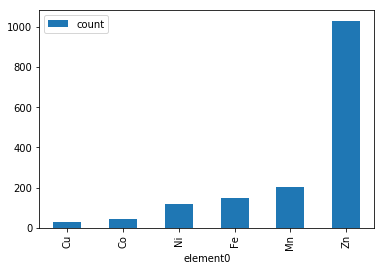

In [9]:
unique_df = unique_ds.toPandas()
unique_df.plot(x='element0', y='count', kind='bar');

## Terminate Spark

In [10]:
spark.stop()